In [40]:
import warnings
warnings.filterwarnings('ignore')


In [41]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.regression.linear_model import RegressionResultsWrapper
from sklearn.base import RegressorMixin

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [45]:
# define a method that will return metrics for plotting influential points
def get_influential_points_summary(model: RegressionResultsWrapper, k: int = 1):
    model_inf = model.get_influence()
    # inf_frame = model_inf.summary_frame()
    # w_cookD = np.argwhere(model_inf.cooks_distance[0] > 1)
    n = len(model.resid)
    # w_leverage = np.argwhere(model_inf.hat_matrix_diag > 2*(k+1)/n)

    inf_plot_frame = pd.DataFrame(columns=['Residuals', 'Leverage', 'Cook Dist.'])

    inf_plot_frame['Residuals'] = model.resid
    inf_plot_frame['Leverage'] = model_inf.hat_matrix_diag
    inf_plot_frame['Cook Dist.'] = model_inf.cooks_distance[0]

    return inf_plot_frame

In [46]:
# define method to plot model performance analyis
def plot_ols_analysis(model: RegressionResultsWrapper, y_true) -> None:
    resid = model.resid
    y_pred = model.predict() 

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    fig.subplots_adjust(hspace=0.4, wspace=.4)

    axes = axes.flatten()

    sns.histplot(resid, element='step', linewidth=.0, ax=axes[0]);
    sns.despine()
    # axes[0].grid(alpha=.3)
    axes[0].set_title('Residuals hisogram', fontsize=10)
    

    sm.qqplot(model.resid, line='q', ax=axes[1])
    sns.despine()
    axes[1].set_title('Q-Q Plot of model residuals', fontsize=10)
    
    ip_summary = get_influential_points_summary(model)
    
    sns.scatterplot(data=ip_summary, x='Leverage', y='Residuals', size='Cook Dist.', hue=(ip_summary['Cook Dist.'] > 1), legend=None, ax=axes[2])
    sns.despine()
    axes[2].set_title("Influence Plot\n Size of the blob corresponds to Cook's distance", fontsize=10);

    sns.scatterplot(x=y_true, y=resid, s=10, ax=axes[3])
    sns.despine()
    axes[3].axhline(y=0, color='red')
    axes[3].grid(alpha=.4)
    axes[3].set_title('Price vs Residual', fontsize=10)
    axes[3].set_xlabel('price')
    axes[3].set_ylabel('residuals')

    sns.scatterplot(x=y_true, y=y_pred, s=10, ax=axes[4])
    sns.despine()
    axes[4].axline((0, 0), (1, 1), color='red')
    axes[4].grid(alpha=.4)
    axes[4].set_title('Price vs Predicted', fontsize=10)
    axes[4].set_xlabel('price')
    axes[4].set_ylabel('predicted')

    sns.scatterplot(x=y_true, y=resid/y_true, s=10, ax=axes[5])
    sns.despine()
    axes[5].axhline(y=0, color='red')
    axes[5].grid(alpha=.4)
    axes[5].set_title('Price vs residual/price', fontsize=10)
    axes[5].set_xlabel('price')
    axes[5].set_ylabel('residual/price')

    fig.suptitle('Model analysis', fontsize=15)

In [47]:
# define method to plot model performance analyis
def plot_regression_analysis(y_true, y_pred) -> None:
    resid = y_true - y_pred
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    fig.subplots_adjust(hspace=0.4, wspace=.4)

    axes = axes.flatten()

    sns.histplot(resid, element='step', linewidth=.0, ax=axes[0]);
    sns.despine()
    # axes[0].grid(alpha=.3)
    axes[0].set_title('Residuals hisogram', fontsize=10)
    

    sm.qqplot(resid, line='q', ax=axes[1])
    sns.despine()
    axes[1].set_title('Q-Q Plot of model residuals', fontsize=10)
    
    # ip_summary = get_influential_points_summary(model)
    
    # sns.scatterplot(data=ip_summary, x='Leverage', y='Residuals', size='Cook Dist.', hue=(ip_summary['Cook Dist.'] > 1), legend=None, ax=axes[2])
    # sns.despine()
    # axes[2].set_title("Influence Plot\n Size of the blob corresponds to Cook's distance", fontsize=10);

    sns.scatterplot(x=y_true, y=resid, s=10, ax=axes[3])
    sns.despine()
    axes[3].axhline(y=0, color='red')
    axes[3].grid(alpha=.4)
    axes[3].set_title('Price vs Residual', fontsize=10)
    axes[3].set_xlabel('price')
    axes[3].set_ylabel('residuals')

    sns.scatterplot(x=y_true, y=y_pred, s=10, ax=axes[4])
    sns.despine()
    axes[4].axline((0, 0), (1, 1), color='red')
    axes[4].grid(alpha=.4)
    axes[4].set_title('Price vs Predicted', fontsize=10)
    axes[4].set_xlabel('price')
    axes[4].set_ylabel('predicted')

    sns.scatterplot(x=y_true, y=resid/y_true, s=10, ax=axes[5])
    sns.despine()
    axes[5].axhline(y=0, color='red')
    axes[5].grid(alpha=.4)
    axes[5].set_title('Price vs residual/price', fontsize=10)
    axes[5].set_xlabel('price')
    axes[5].set_ylabel('residual/price')

    fig.suptitle('Model analysis', fontsize=15)

In [48]:
def plot_regularization_analysis(model, X, y, alpha_range=None):
    r2_scores_train = []
    r2_scores_test  = []

    mse_scores_train = []
    mse_scores_test = []

    parameters = []

    alpha_range = np.logspace(-4, 10, 300)

    for alpha in alpha_range:
        estimator = model(normalize=True, alpha=alpha)
        estimator.fit(X, y)

        r2_scores_train.append(estimator.score(X, y))
        mse_scores_train.append(mean_squared_error(estimator.predict(X), y))
        parameters.append(estimator.coef_)

    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20, 5))

    ax[0].plot(alpha_range, r2_scores_train, label='r2_train')
    # ax[0].plot(alpha_range, r2_scores_test, label='r2_test')
    ax[0].set_xscale('log')
    # ax[0].axvline(x=0.01, color='red')
    ax[0].legend(frameon=False)
    ax[0].grid()
    ax[0].set_title('r2 scores')


    ax[1].plot(alpha_range, mse_scores_train, label='mse_train')
    # ax[1].plot(alpha_range, mse_scores_test, label='mse_test')
    ax[1].set_xscale('log')
    ax[1].legend(frameon=False)
    ax[1].set_title('mse score')

    ax[2].plot(alpha_range, parameters)
    ax[2].set_xscale('log')
    ax[2].set_title('alpha');


## Load data

In [49]:
df = pd.read_csv('_data/kc_house_data.csv')

In [50]:
df = df.drop(columns = ['id', 'lat', 'long', 'date', 
                        'zipcode', 'yr_renovated', 'waterfront', 
                        'view', 'sqft_basement'])

In [51]:
df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,3,8,1530,2009,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,3,8,2310,2014,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,3,7,1020,2009,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,3,8,1600,2004,1410,1287


In [52]:
df['years_old'] = df['yr_built'].max() - df['yr_built']

<AxesSubplot:xlabel='bedrooms', ylabel='count'>

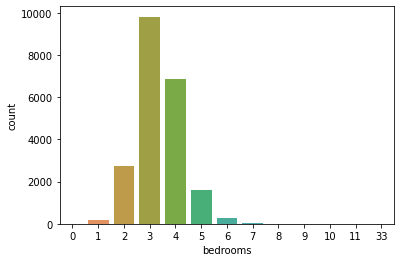

In [56]:
sns.countplot(df['bedrooms'].astype('category'))

## EDA

<AxesSubplot:>

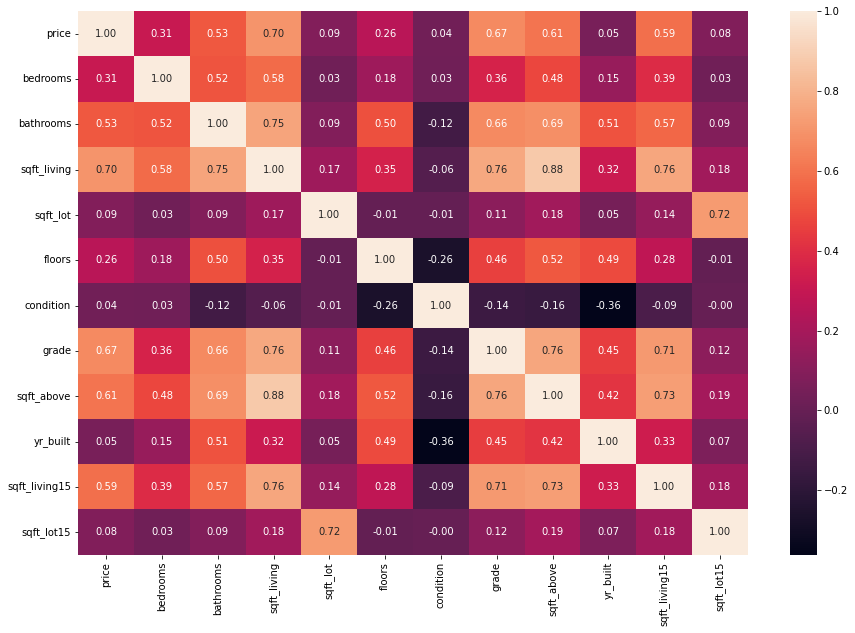

In [13]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, fmt='.2f')

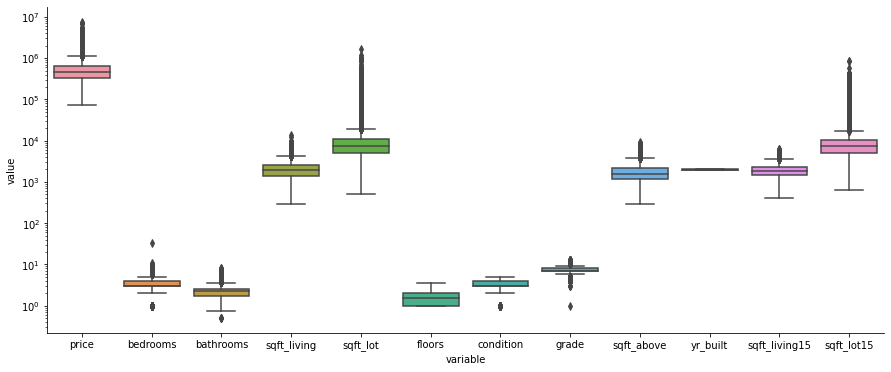

In [14]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='variable', y='value', data=df.melt())
sns.despine()
plt.yscale('log')

## OLS

In [15]:
formula = 'price ~ ' + ' + '.join([i for i in df.drop(columns=['price']).columns])
formula

'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + condition + grade + sqft_above + yr_built + sqft_living15 + sqft_lot15'

In [16]:
model = smf.ols(formula=formula, data=df).fit(data=df)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     3202.
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        16:59:25   Log-Likelihood:            -2.9715e+05
No. Observations:               21613   AIC:                         5.943e+05
Df Residuals:                   21601   BIC:                         5.944e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.933e+06   1.36e+05     51.002      0.000    6.67e+06     7.2e+06
bedrooms      -4.936e+04   2108.805    -23.406      0.000   -5.35e+04   -4.52e+04
bathrooms       5.01e+04   3625.970     13.817      0.000     4.3e+04    5.72e+04
sqft_living     195.1515      4.812     40.552      0.000     185.719     204.584
sqft_lot          0.0111      0.054      0.207      0.836      -0.094       0.116
floors         3.348e+04   3957.258      8.461      0.000    2.57e+04    4.12e+04
condition      1.898e+04   2580.038      7.356      0.000    1.39e+04     2.4e+04
grade          1.246e+05   2346.774     53.099      0.000     1.2e+05    1.29e+05
sqft_above      -28.6643      4.678     -6.128      0.000     -37.833     -19.496
yr_built      -3968.3906     69.774    -56.875      0.000   -4105.152   -3831.629
sqft_living15    36.2656      3.735      9.709      0.000      28.944      43.587
sqft_lot15       -0.5066      0.082     -6.172      0.000      -0.667      -0.346
==============================================================================
Omnibus:                    17771.672   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1362466.098
Skew:                           3.467   Prob(JB):                         0.00
Kurtosis:                      41.274   Cond. No.                     4.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

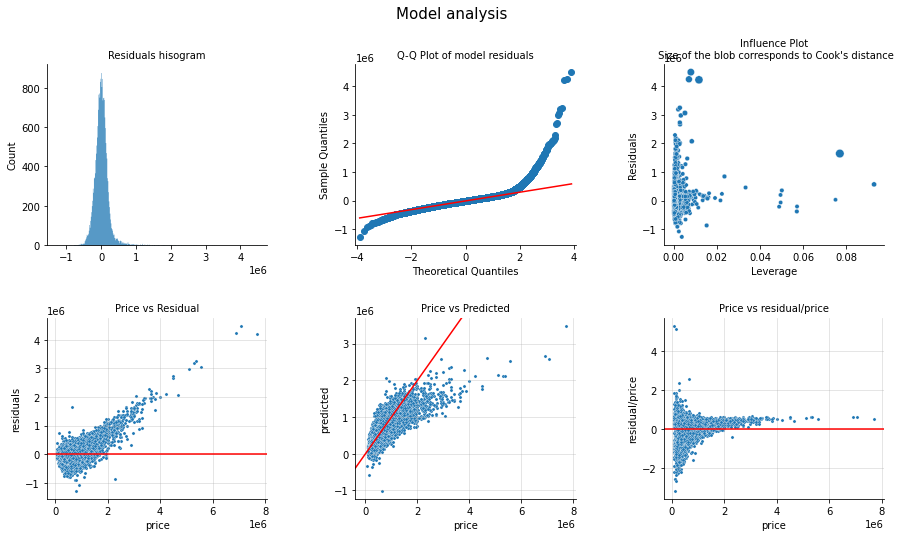

In [17]:
plot_ols_analysis(model, df.price)

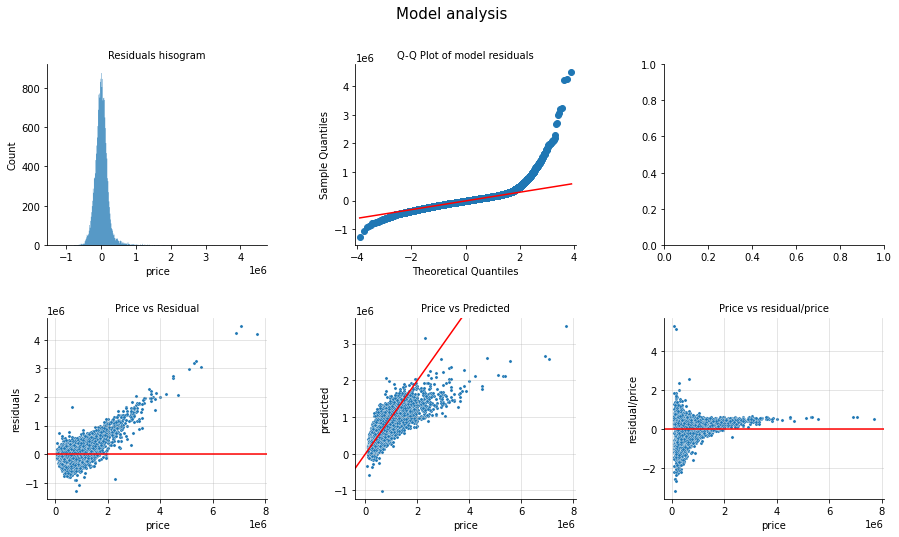

In [18]:
plot_regression_analysis(df.price, model.predict())

---

## Ridge - Whole DATA

In [19]:
X_train, y_train = df.drop(columns=['price']), df['price']

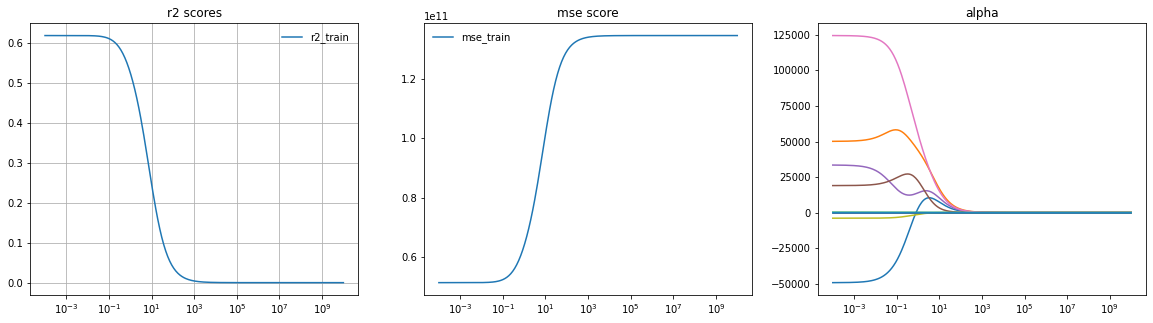

In [20]:
plot_regularization_analysis(Ridge, X_train, y_train, alpha_range=np.logspace(-5, 5, 300))

## Lasso - Whole DATA

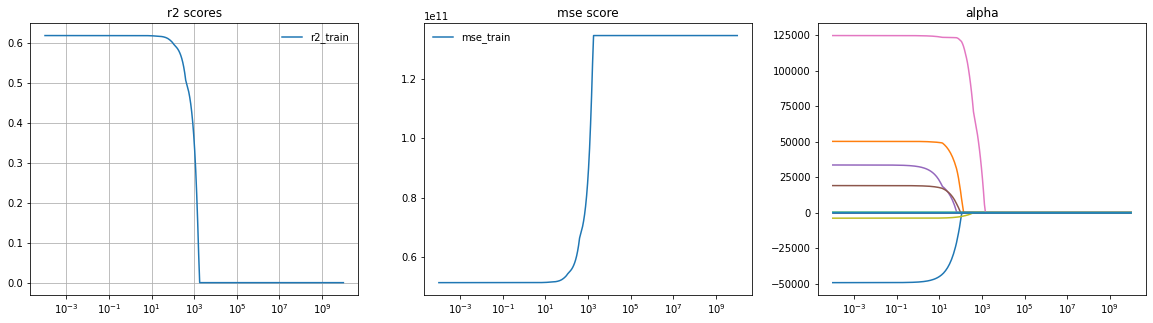

In [21]:
plot_regularization_analysis(Lasso, X_train, y_train, alpha_range=np.logspace(-5, 5, 300))

## Ridge and Lasso on train/test split

In [31]:
_X_train, _X_test, _y_train, _y_test = train_test_split(df.drop(columns=['price']), 
                                                        df['price'], 
                                                        train_size=.2,
                                                        random_state=42, 
                                                        shuffle=True)

In [32]:
model_a = smf.ols(formula=formula, data=pd.concat([_X_train, _y_train], axis=1)).fit(data=pd.concat([_X_train, _y_train], axis=1))
model_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     669.7
Date:                Fri, 05 May 2023   Prob (F-statistic):               0.00
Time:                        17:02:32   Log-Likelihood:                -59043.
No. Observations:                4322   AIC:                         1.181e+05
Df Residuals:                    4310   BIC:                         1.182e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.916e+06   2.78e+05     24.894      0.000    6.37e+06    7.46e+06
bedrooms      -5.083e+04   4693.961    -10.830      0.000      -6e+04   -4.16e+04
bathrooms       5.43e+04   7542.840      7.199      0.000    3.95e+04    6.91e+04
sqft_living     174.8486     10.103     17.306      0.000     155.041     194.656
sqft_lot          0.1693      0.140      1.213      0.225      -0.104       0.443
floors          4.25e+04   8131.305      5.227      0.000    2.66e+04    5.84e+04
condition      1.848e+04   5357.307      3.450      0.001    7981.485     2.9e+04
grade          1.222e+05   4775.173     25.593      0.000    1.13e+05    1.32e+05
sqft_above      -28.4060      9.559     -2.972      0.003     -47.146      -9.666
yr_built      -3933.7238    142.331    -27.638      0.000   -4212.765   -3654.683
sqft_living15    32.8526      7.650      4.294      0.000      17.854      47.851
sqft_lot15       -0.7897      0.191     -4.138      0.000      -1.164      -0.416
==============================================================================
Omnibus:                     2140.258   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28424.081
Skew:                           2.031   Prob(JB):                         0.00
Kurtosis:                      14.889   Cond. No.                     4.26e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.26e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

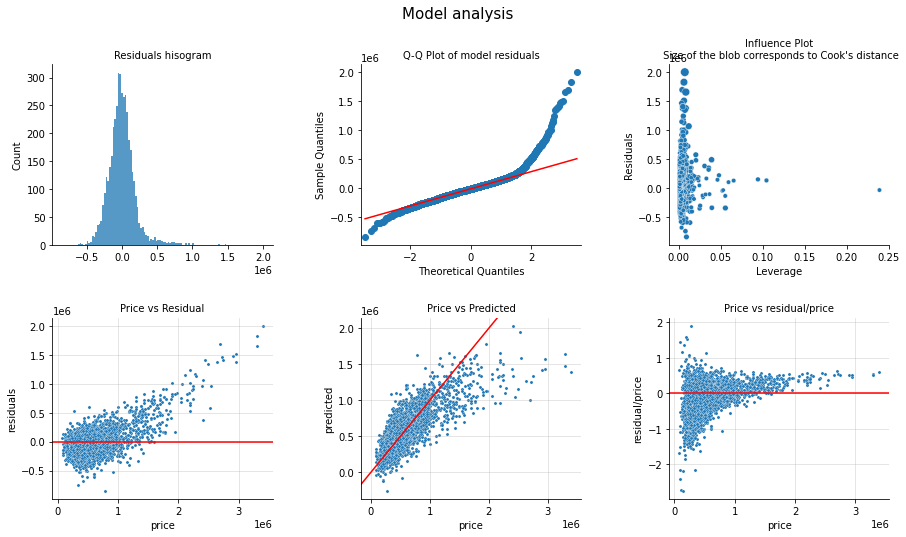

In [34]:
plot_ols_analysis(model_a, _y_train)

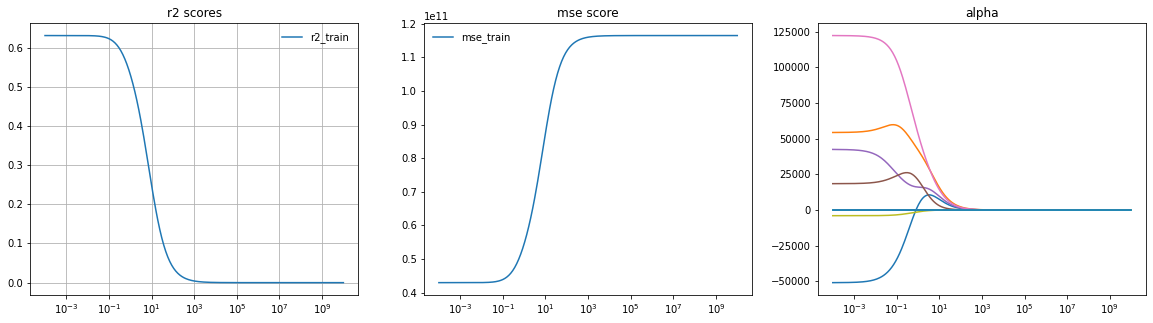

In [ ]:
plot_regularization_analysis(Ridge, _X_train, _y_train, alpha_range=np.logspace(-5, 5, 300))

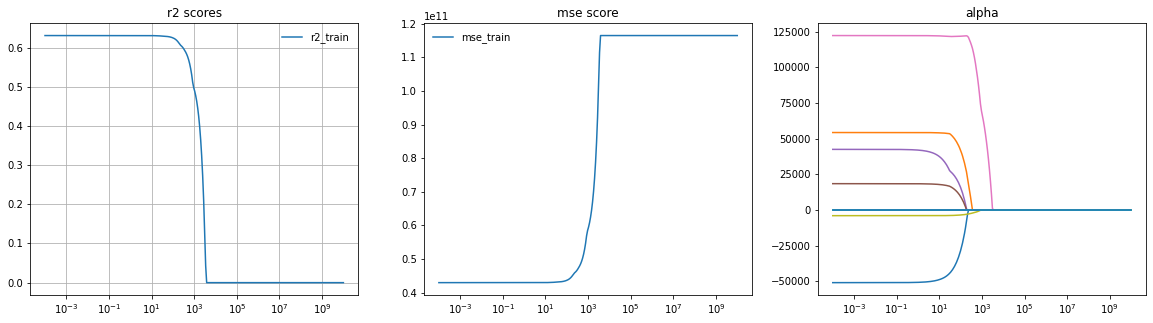

In [ ]:
plot_regularization_analysis(Lasso, _X_train, _y_train, alpha_range=np.logspace(-5, 5, 300))

## Ridge and Lasso CV

In [36]:
gs = GridSearchCV(Ridge(normalize=True), param_grid={'alpha': np.logspace(-4, 10, 300)}, cv=5, scoring='neg_mean_squared_error')
gs.fit(_X_train, _y_train)

GridSearchCV(cv=5, estimator=Ridge(normalize=True),
             param_grid={'alpha': array([1.00000000e-04, 1.11383983e-04, 1.24063916e-04, 1.38187331e-04,
       1.53918552e-04, 1.71440614e-04, 1.90957383e-04, 2.12695939e-04,
       2.36909207e-04, 2.63878910e-04, 2.93918840e-04, 3.27378510e-04,
       3.64647222e-04, 4.06158599e-04, 4.52395623e-04, 5.03896263e-04,
       5.61259726e-04, 6.25153435e-04, 6.9...
       8.37677640e+08, 9.33038717e+08, 1.03925568e+09, 1.15756437e+09,
       1.28934130e+09, 1.43611969e+09, 1.59960730e+09, 1.78170632e+09,
       1.98453546e+09, 2.21045463e+09, 2.46209240e+09, 2.74237657e+09,
       3.05456825e+09, 3.40229977e+09, 3.78961698e+09, 4.22102632e+09,
       4.70154722e+09, 5.23677054e+09, 5.83292359e+09, 6.49694260e+09,
       7.23655342e+09, 8.06036141e+09, 8.97795155e+09, 1.00000000e+10])},
             scoring='neg_mean_squared_error')

In [37]:
best_alpha = gs.best_estimator_.alpha
best_alpha

0.004353073364731888

In [38]:
ridge = Ridge(alpha=best_alpha, normalize=True)

ridge.fit(_X_train, _y_train)

Ridge(alpha=0.004353073364731888, normalize=True)

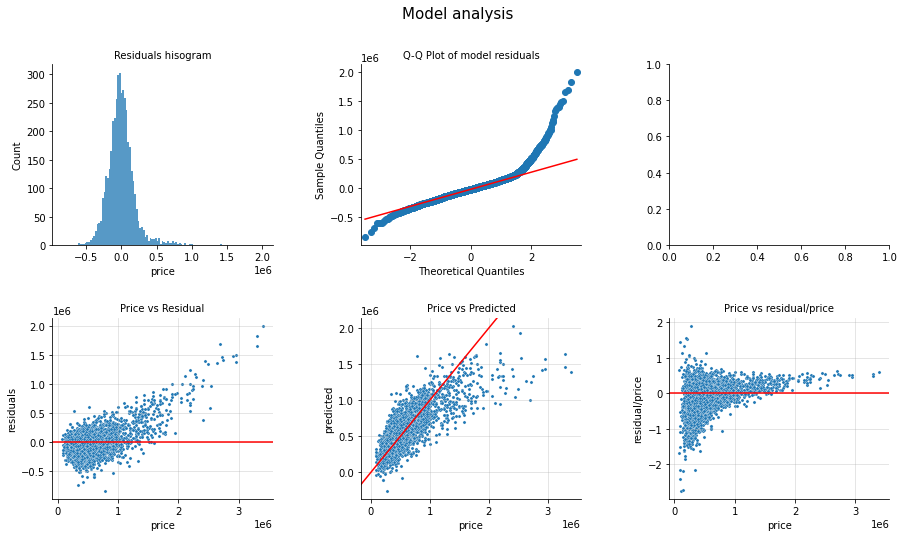

In [39]:
plot_regression_analysis(_y_train, ridge.predict(_X_train))